In [1]:
import networkx as nx
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx

In [3]:
plt.rcParams["figure.figsize"] = (20,3)

In [4]:
from shared.schema import DatasetSchema, GraphSchema
from shared.graph import DataGraph, igraph_to_nx

from datasets.visualization import plot_explore_dual_histogram, show_top_k_nodes, show_top_k_stacked_nodes

In [5]:
DATASET = DatasetSchema.load_schema('sx-superuser')
schema = GraphSchema.from_dataset(DATASET)
G = DataGraph.from_schema(schema)

In [6]:
TIMESTAMP_BINS = 50
K = 10
HAS_NODE_TIMESTAMP = schema.is_node_temporal()
HAS_EDGE_TIMESTAMP = schema.is_edge_temporal()
BETWEENESS_K = 1

print('Has node timestamp: {}'.format(HAS_NODE_TIMESTAMP))
print('Has edge timestamp: {}'.format(HAS_EDGE_TIMESTAMP))

Has node timestamp: False
Has edge timestamp: True


# Dataset Specific Statistics

## Visualize Distribution of Nodes over Time

In [7]:
NODE_TIMESTAMPS = pd.Series(G.vs['timestamp'], name='timestamp', index=G.vs['name']) if HAS_NODE_TIMESTAMP else None
EDGE_TIMESTAMPS = pd.Series(G.es['timestamp'], name='timestamp', index=range(G.ecount())) if HAS_EDGE_TIMESTAMP else None
LABELS = pd.Series(G.vs['label'], name='label', index=G.vs['name'])

In [8]:
if HAS_NODE_TIMESTAMP:
    NODE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(NODE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Nodes over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Nodes')
else:
    print('No node timestamp data available')

No node timestamp data available


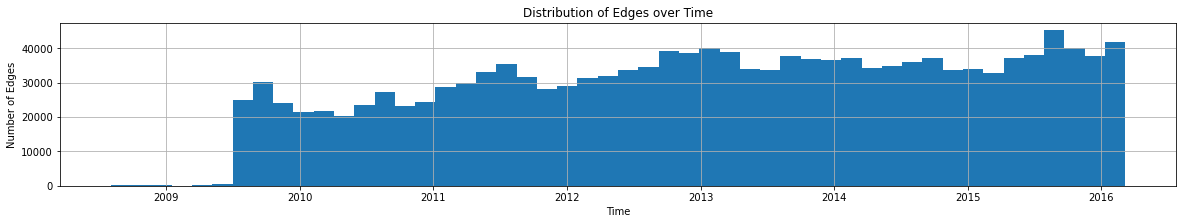

In [9]:
if HAS_EDGE_TIMESTAMP:
    EDGE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(EDGE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Edges over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Edges')
else:
    print('No edge timestamp data available')

# Global Statistics

In [10]:
print(f'Number of Nodes: {G.vcount()}')
print(f'Number of Edges: {G.ecount()}')
print(f'Density: {G.density()}')

Number of Nodes: 194085
Number of Edges: 1443339
Density: 3.831657134954338e-05


In [11]:
degrees = pd.Series(G.degree(), index=G.vs['name'])

In [12]:
print(f'Average Degree: {np.mean(degrees)}')
print(f'Median Degree: {np.median(degrees)}')

Average Degree: 14.873266867609553
Median Degree: 3.0


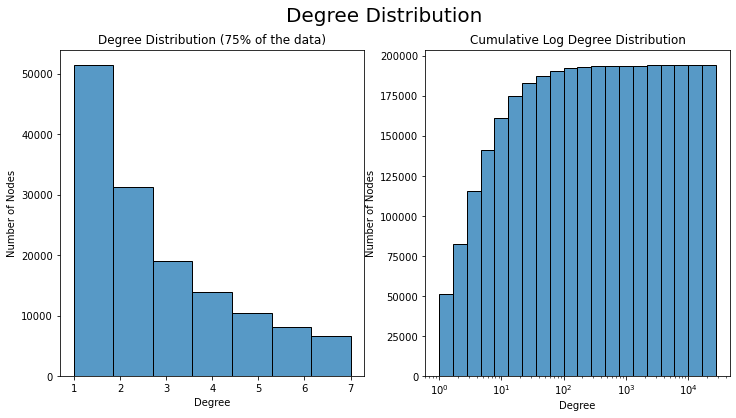

In [13]:
plot_explore_dual_histogram(
    series=degrees,
    title='Degree Distribution',
    title_short='Degree Distribution',
    xlabel='Degree',
    ylabel='Number of Nodes',
    normalize=False,
)
plt.show()

In [14]:
show_top_k_nodes(
    degrees,
    LABELS,
    title='Degree Nodes'
)

Top 10 Degree Nodes


,value,label
0,27637,83283
1,19727,8672
2,16408,23133
3,14801,48078
4,13533,1686
5,12014,40928
6,11804,10165
7,10925,337631
8,10110,174557
9,9433,138343


## Connectivity Metrics
* **degree_centrality**: Degree centrality of a node is the fraction of nodes it is connected to.
* **closeness_centrality**: Closeness centrality of a node is the inverse of the average shortest path length to all other nodes.
* **betweenness_centrality**: Betweenness centrality of a node is the fraction of all shortest paths in the network that pass through it.
* **eigenvector_centrality**: Eigenvector centrality of a node is the normalized sum of the eigenvector centralities of all its neighbors.
* **pagerank**: PageRank is a ranking of nodes based on the structure of the network.
* **transitivity**: Clustering coefficient is the fraction of triangles that are formed by a node and its neighbors.

In [15]:
# Use the largest connected component
G_cc = G.components("weak").giant()
G_cc.to_undirected()

# Convert to NetworkX
nx_G = igraph_to_nx(G_cc)
nx_Gu = nx.Graph(nx_G)

In [16]:
print('Average Clustering Coefficient: {}'.format(nx.approximation.average_clustering(nx_Gu)))
print('Diameter: {}'.format(nx.approximation.diameter(nx_Gu)))

Average Clustering Coefficient: 0.24
Diameter: 12


In [17]:
# Calculate the metrics
metrics_dict = {}

metrics_dict['degree_centrality'] = nx.degree_centrality(nx_G)
try:
    metrics_dict['betweenness_centrality'] = nx.betweenness_centrality(nx_Gu, k=BETWEENESS_K)
except Exception as e:
    print('Betweenness Centrality Error: {}'.format(e))
try:
    metrics_dict['eigenvector_centrality'] = nx.eigenvector_centrality(nx_Gu)
except Exception as e:
    print('Eigenvector Centrality Error: {}'.format(e))
metrics_dict['page_rank'] = nx.pagerank(nx_Gu)
metrics_dict['transitivity'] = dict(zip(G_cc.vs['name'], G_cc.transitivity_local_undirected()))

NODE_STATS = pd.DataFrame(metrics_dict)
NODE_STATS.describe()

,degree_centrality,betweenness_centrality,eigenvector_centrality,page_rank,transitivity
count,189191.000000,189191.000000,1.891910e+05,189191.000000,119565.000000
mean,0.000044,0.000013,6.204263e-04,0.000005,0.188512
std,0.000358,0.002216,2.213766e-03,0.000043,0.299599
min,0.000005,0.000000,4.123157e-14,0.000001,0.000000
25%,0.000005,0.000000,1.925823e-05,0.000002,0.000000
50%,0.000016,0.000000,1.418075e-04,0.000002,0.035714
75%,0.000026,0.000000,6.118529e-04,0.000004,0.266667
max,0.075564,0.957745,2.097980e-01,0.010164,1.000000


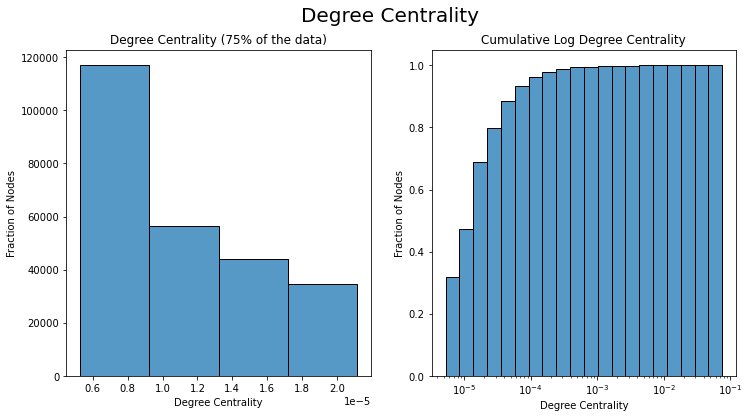

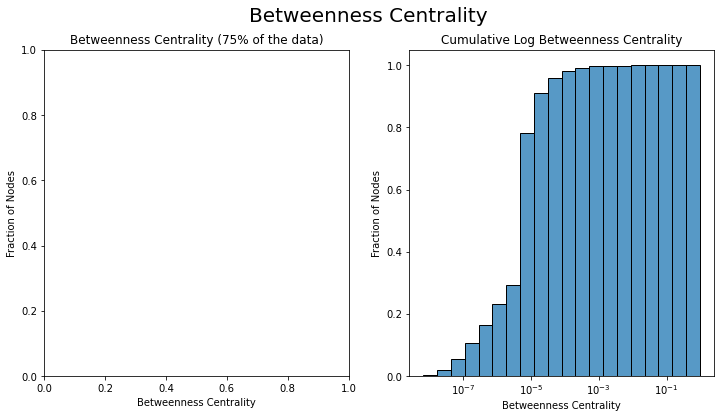

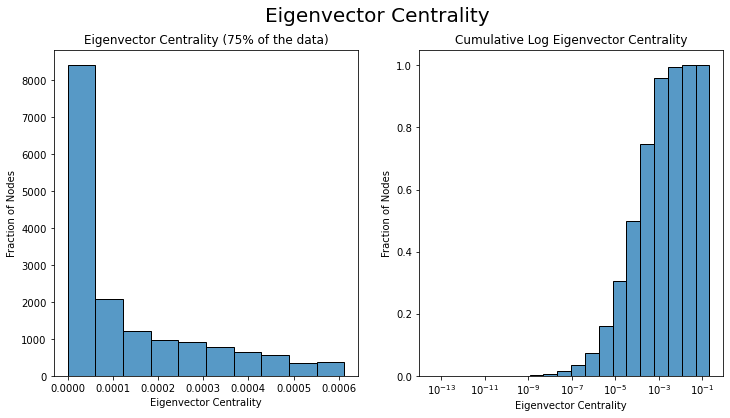

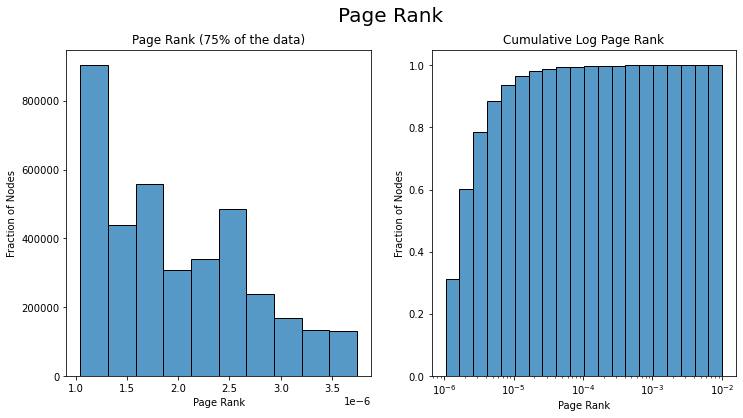

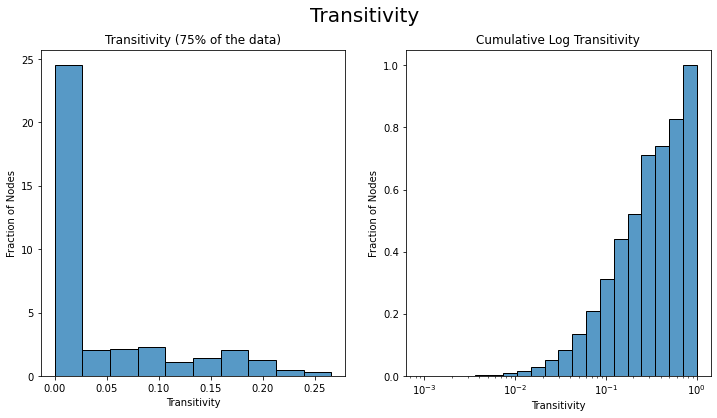

In [18]:
for col in NODE_STATS.columns:
    title = col.replace('_', ' ').title()
    data = NODE_STATS[col][np.isfinite(NODE_STATS[col])]
    try:
        plot_explore_dual_histogram(
            series=data,
            title=title,
            title_short=title,
            xlabel=title,
            ylabel='Fraction of Nodes',
            normalize=True,
        )
        plt.show()
    except:
        print(f'Failed to plot {title}')

In [19]:
show_top_k_stacked_nodes(
    NODE_STATS,
    LABELS,
    title='Nodes by Statistic',
)

Top 10 Nodes by Statistic


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.075564,83283,0.957745,4377,0.209798,83283,0.010164,83283,1.0,61868
1,0.042481,23133,0.058140,83283,0.157500,23133,0.005337,23133,1.0,45785
2,0.033014,48078,0.041087,12834,0.137123,8672,0.004578,337631,1.0,305171
3,0.028210,40928,0.039929,23133,0.133180,10165,0.004132,48078,1.0,45791
4,0.027739,337631,0.024948,48078,0.132948,1686,0.003168,40928,1.0,455998
5,0.027470,1686,0.018344,1686,0.131619,40928,0.003066,1686,1.0,455960
6,0.026983,10165,0.017722,174557,0.125951,48078,0.003015,10165,1.0,455913
7,0.024452,8672,0.017164,10165,0.100553,3279,0.002725,138343,1.0,223866
8,0.021407,138343,0.015964,40928,0.099574,4386,0.002433,174557,1.0,45805
9,0.020054,121352,0.015628,138343,0.092774,26316,0.002407,364367,1.0,107208


## Connected Components Statistics

In [20]:
print(f'Number of Connected Components: {len(G.components("weak"))}')
largest_cc = G.components("weak").giant()
print(f'Size of the largest component: {largest_cc.vcount()}')

Number of Connected Components: 3197
Size of the largest component: 189191


Text(0.5, 1.0, 'Connected Components')

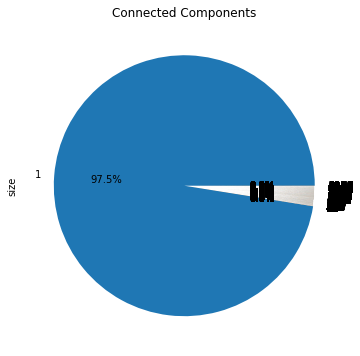

In [21]:
df_tmp = pd.DataFrame([{'size': len(c)} for i,c in enumerate(G.components("weak"))], index=range(1,len(G.components("weak"))+1))
ax = df_tmp.plot.pie(
    y='size',
    figsize=(6,6),
    autopct='%1.1f%%',
    legend=False,
)
ax.set_title('Connected Components')

# Type Specific Statistics

### Node Type Statistics

In [22]:
node_types = schema.get_node_types()
node_type_stats = pd.DataFrame([
    {
        'type': node_type,
        'count': len(G.vs.select(type=node_type)),
        'degree_avg': np.mean(G.vs.select(type=node_type).degree()),
        'degree_median': np.median(G.vs.select(type=node_type).degree()),
    }
    for node_type in node_types
], index=node_types)
print('Node Type count: {}'.format(len(node_types)))
node_type_stats

Node Type count: 1


,type,count,degree_avg,degree_median
User,User,194085,14.873267,3.0


<AxesSubplot:title={'center':'Node type counts'}, ylabel='count'>

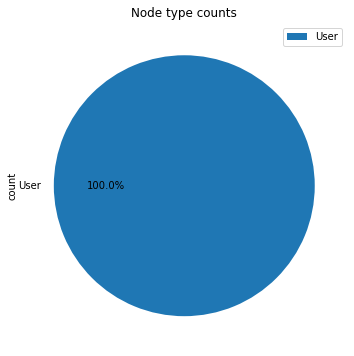

In [23]:
node_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Node type counts', figsize=(6,6))

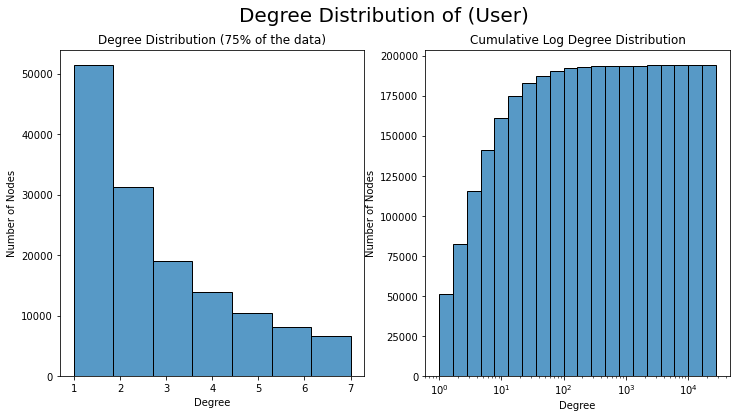

In [24]:
for node_type in node_types:
    degrees = pd.Series(G.vs.select(type=node_type).degree())
    plot_explore_dual_histogram(
        series=degrees,
        title=f'Degree Distribution of ({node_type})',
        title_short='Degree Distribution',
        xlabel='Degree',
        ylabel='Number of Nodes',
    )
    plt.show()

In [25]:
for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    data = pd.Series(nodes.degree(), index=nodes['name'])
    show_top_k_nodes(
        data,
        LABELS,
        title=f'Degree Nodes of Type ({node_type})'
    )

Top 10 Degree Nodes of Type (User)


,value,label
0,27637,83283
1,19727,8672
2,16408,23133
3,14801,48078
4,13533,1686
5,12014,40928
6,11804,10165
7,10925,337631
8,10110,174557
9,9433,138343


### Edge Type Statistics

In [26]:
edge_types = schema.get_edge_types()
edge_type_stats = pd.DataFrame([
    {
        'type': edge_type,
        'count': len(G.es.select(type=edge_type)),
    }
    for edge_type in edge_types
], index=edge_types)
print('Edge Type count: {}'.format(len(edge_types)))
edge_type_stats

Edge Type count: 3


,type,count
ANSWERED_QUESTION,ANSWERED_QUESTION,430033
COMMENTED_ON_ANSWER,COMMENTED_ON_ANSWER,534239
COMMENTED_ON_QUESTION,COMMENTED_ON_QUESTION,479067


<AxesSubplot:title={'center':'Edge type counts'}, ylabel='count'>

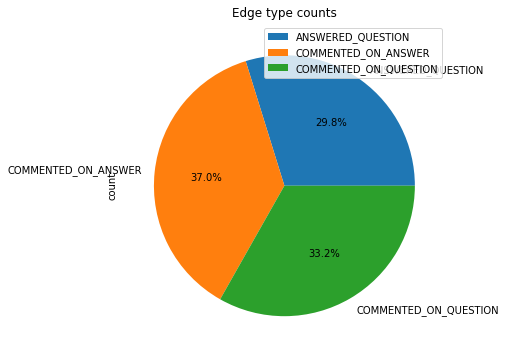

In [27]:
edge_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Edge type counts', figsize=(6,6))

## Node Type Connectivity Statistics

In [28]:
node_stats_by_type = {}

for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    names = set(nodes['name']) & set(NODE_STATS.index)

    node_stats_by_type[node_type] = NODE_STATS.loc[names]

In [29]:
for node_type in node_types:
    show_top_k_stacked_nodes(
        node_stats_by_type[node_type],
        LABELS,
        title=f'Nodes by Statistic for {node_type}',
    )

Top 10 Nodes by Statistic for User


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.075564,83283,0.957745,4377,0.209798,83283,0.010164,83283,1.0,95425
1,0.042481,23133,0.058140,83283,0.157500,23133,0.005337,23133,1.0,396351
2,0.033014,48078,0.041087,12834,0.137123,8672,0.004578,337631,1.0,302845
3,0.028210,40928,0.039929,23133,0.133180,10165,0.004132,48078,1.0,373878
4,0.027739,337631,0.024948,48078,0.132948,1686,0.003168,40928,1.0,54671
5,0.027470,1686,0.018344,1686,0.131619,40928,0.003066,1686,1.0,140309
6,0.026983,10165,0.017722,174557,0.125951,48078,0.003015,10165,1.0,458147
7,0.024452,8672,0.017164,10165,0.100553,3279,0.002725,138343,1.0,458151
8,0.021407,138343,0.015964,40928,0.099574,4386,0.002433,174557,1.0,341662
9,0.020054,121352,0.015628,138343,0.092774,26316,0.002407,364367,1.0,19849


# Clustering

## No Clustering Modularity

In [30]:
n = G_cc.vcount()
print(f'Initial modularity: {G_cc.modularity(np.ones(n))}')

Initial modularity: 0.0


### Louvain

In [31]:
louvain = G_cc.community_multilevel()
print(f'Modularity after Louvain: {G_cc.modularity(louvain)}')
print(f'Number of communities: {len(louvain)}')

Modularity after Louvain: 0.45720043768997287
Number of communities: 330


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

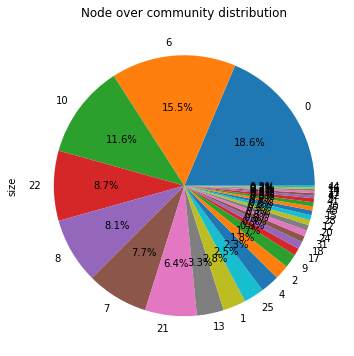

In [32]:
community_sizes = pd.Series(list(map(len, louvain)), name='size', index=range(len(louvain)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

In [33]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(louvain))):
    # Show top k nodes
    community_node_names = names.loc[louvain[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )

    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No node timestamp data available')

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.024452,8672,0.957745,4377,0.137123,8672,0.002284,8672,1.0,37983
1,0.015450,26316,0.013484,8672,0.099574,4386,0.001549,26316,1.0,16445
2,0.014419,4386,0.009167,4386,0.092774,26316,0.001300,4377,1.0,246342
3,0.012971,4377,0.008208,26316,0.086325,4377,0.001282,4386,1.0,71949
4,0.012062,1931,0.006390,482,0.083583,9666,0.001054,482,1.0,16124
5,0.011100,482,0.005039,9666,0.079748,1931,0.001046,9666,1.0,71812
6,0.011068,9666,0.004872,820,0.076959,289,0.001014,1931,1.0,16180
7,0.009350,289,0.004823,1931,0.069784,482,0.000886,820,1.0,71647
8,0.009150,12786,0.003755,310,0.068565,43749,0.000810,289,1.0,71499
9,0.008494,820,0.003676,289,0.060498,20088,0.000739,12786,1.0,71054


No node timestamp data available
Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.033014,48078,0.024948,48078,0.125951,48078,0.004132,48078,1.0,566697
1,0.003182,110524,0.001175,129520,0.022684,129520,0.000507,110524,1.0,278799
2,0.001713,180990,0.001062,110524,0.020196,71001,0.000182,180990,1.0,83989
3,0.001580,71001,0.000383,29051,0.011509,180990,0.000161,71001,1.0,272872
4,0.001480,129520,0.000367,30791,0.010225,30791,0.000134,129520,1.0,83374
5,0.000951,26250,0.000250,74576,0.009138,26250,0.000106,266231,1.0,274430
6,0.000835,39364,0.000223,180990,0.009113,31641,0.000104,114058,1.0,274779
7,0.000761,266231,0.000216,48615,0.008970,39364,0.000099,26250,1.0,275331
8,0.000671,20798,0.000207,298823,0.008456,52387,0.000087,39364,1.0,276230
9,0.000655,71809,0.000203,104286,0.008226,39752,0.000084,354491,1.0,276528


No node timestamp data available
Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.026983,10165,0.017164,10165,0.133180,10165,0.003015,10165,1.0,106212
1,0.003658,144961,0.002567,144961,0.024968,144961,0.000407,144961,1.0,79969
2,0.001279,156043,0.000522,82524,0.016387,82524,0.000138,156043,1.0,255935
3,0.001184,85927,0.000420,70010,0.013085,85927,0.000116,93929,1.0,79415
4,0.000920,93929,0.000217,41727,0.011941,156043,0.000110,85927,1.0,510535
5,0.000798,31972,0.000178,156043,0.010392,31972,0.000089,31972,1.0,77026
6,0.000766,82524,0.000162,93929,0.009425,7401,0.000076,82524,1.0,202714
7,0.000703,7401,0.000150,20824,0.008593,70010,0.000074,326546,1.0,146416
8,0.000692,326546,0.000148,31972,0.008332,29062,0.000067,20824,1.0,76307
9,0.000529,20824,0.000144,29062,0.007965,100059,0.000064,7401,1.0,325044


No node timestamp data available
Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000021,61,0.000005,61,7.051254e-05,61,0.000005,61,0.0,61
1,0.000005,423801,0.000000,423801,3.347502e-07,423801,0.000002,423801,NaN,423801


No node timestamp data available
Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.042481,23133,0.041087,12834,0.157500,23133,0.005337,23133,1.0,324297
1,0.003319,4880,0.039929,23133,0.029824,4880,0.000399,183984,1.0,340004
2,0.003245,183984,0.000938,46099,0.021336,183984,0.000331,4880,1.0,225216
3,0.001237,46099,0.000568,7493,0.021290,85308,0.000117,46099,1.0,142579
4,0.001184,85308,0.000554,85308,0.017909,46099,0.000115,85308,1.0,523668
5,0.001094,7493,0.000522,183984,0.011023,7493,0.000115,208950,1.0,252911
6,0.000983,208950,0.000412,33582,0.010076,208950,0.000110,7493,1.0,408592
7,0.000825,10120,0.000362,4880,0.009135,88132,0.000089,10120,1.0,317435
8,0.000729,39401,0.000239,48044,0.008925,51000,0.000077,224976,1.0,385309
9,0.000618,224976,0.000214,8342,0.008660,48044,0.000076,39401,1.0,224316


No node timestamp data available
Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.003594,51300,0.000694,51300,0.025383,51300,0.000397,51300,1.0,332111
1,0.001575,43008,0.000172,43008,0.013405,43008,0.000154,43008,1.0,71727
2,0.000248,44469,0.000070,235529,0.005043,92,0.000032,44469,1.0,264988
3,0.000227,104867,0.000049,207268,0.003540,105880,0.000029,92,1.0,273149
4,0.000227,92,0.000037,225581,0.003120,104867,0.000026,225581,1.0,68676
5,0.000169,105880,0.000037,205919,0.003050,160331,0.000026,207268,1.0,329797
6,0.000137,26486,0.000036,92,0.002645,135758,0.000023,205919,1.0,60026
7,0.000132,139363,0.000032,44469,0.002604,92527,0.000023,104867,1.0,108844
8,0.000127,34824,0.000029,26486,0.002410,26486,0.000020,26486,1.0,74078
9,0.000122,205919,0.000028,104867,0.002394,51291,0.000018,34824,1.0,242692


No node timestamp data available


### Label Propagation

In [34]:
label_prop = G_cc.community_label_propagation()
print(f'Modularity after Label Propagation: {G_cc.modularity(label_prop)}')
print(f'Number of communities: {len(label_prop)}')

Modularity after Label Propagation: 0.01245991284258722
Number of communities: 1563


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

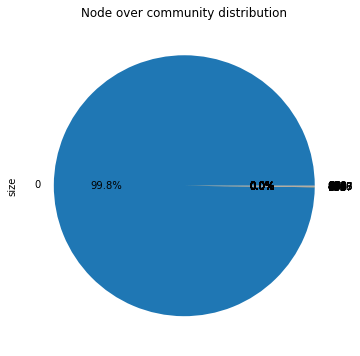

In [35]:
community_sizes = pd.Series(list(map(len, label_prop)), name='size', index=range(len(label_prop)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

In [36]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(label_prop))):
    # Show top k nodes
    community_node_names = names.loc[label_prop[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )


    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No timestamp data available')

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.075564,83283,0.957745,4377,0.209798,83283,0.010164,83283,1.0,189816
1,0.042481,23133,0.058140,83283,0.157500,23133,0.005337,23133,1.0,113943
2,0.033014,48078,0.041087,12834,0.137123,8672,0.004578,337631,1.0,290758
3,0.028210,40928,0.039929,23133,0.133180,10165,0.004132,48078,1.0,290795
4,0.027739,337631,0.024948,48078,0.132948,1686,0.003168,40928,1.0,290838
5,0.027470,1686,0.018344,1686,0.131619,40928,0.003066,1686,1.0,473019
6,0.026983,10165,0.017722,174557,0.125951,48078,0.003015,10165,1.0,290896
7,0.024452,8672,0.017164,10165,0.100553,3279,0.002725,138343,1.0,473001
8,0.021407,138343,0.015964,40928,0.099574,4386,0.002433,174557,1.0,472970
9,0.020054,121352,0.015628,138343,0.092774,26316,0.002407,364367,1.0,113872


No timestamp data available
Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000021,61,0.000005,61,7.051254e-05,61,0.000005,61,0.0,61
1,0.000005,423801,0.000000,423801,3.347502e-07,423801,0.000002,423801,NaN,423801


No timestamp data available
Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000021,93567,0.000005,93567,3.994764e-07,93567,0.000006,93567,0.0,93567
1,0.000005,370,0.000000,370,1.887581e-09,370,0.000003,370,NaN,370


No timestamp data available
Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000021,922,0.000005,922,0.000476,922,0.000005,922,0.0,922
1,0.000005,7125,0.000000,7125,0.000002,7125,0.000002,7125,NaN,7125


No timestamp data available
Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000021,1382,0.000005,1382,1.468350e-05,1382,0.000005,1382,0.0,1382
1,0.000005,274036,0.000000,274036,6.974417e-08,274036,0.000002,274036,NaN,274036


No timestamp data available
Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000037,1403,0.000016,1403,3.840222e-06,1403,0.000011,1403,0.0,1403
1,0.000005,45559,0.000000,45559,1.823285e-08,45559,0.000002,45559,NaN,45559
2,0.000005,85795,0.000000,85795,1.823285e-08,85795,0.000002,85795,NaN,85795
3,0.000005,195003,0.000000,195003,1.823285e-08,195003,0.000002,195003,NaN,195003


No timestamp data available
